This notebook shows how to use [Distance Correlation](https://en.wikipedia.org/wiki/Distance_correlation) (DisCo) as a penalty term in the training of a neural network (using Keras + Tensorflow) to encourage the neural network output to be statistically independent from a given feature.  This is often used in high-energy physics for resonance searches ("bump hunt") when there is one special feature (often a mass of some sort) that is used to look for a localized feature on top of a smoothly falling background.  Other features are used to enhance any potential signals.  It is important for the background estimation that any requirements made on other non-mass features do not sculpt artificial bumps in the mass distribution.  Making the mass and the non-mass features (represented here by a single neural network) is sufficient for this purpose.  See [ATL-PHYS-PUB-2018-014](https://cds.cern.ch/record/2630973) (and references therein and papers that cite it) for a nice review of decorrelation methods.

This idea is based on work by David Shih and Gregor Kasieczka (see p71 [in this talk](https://indico.cern.ch/event/753914/contributions/3440387/attachments/1884206/3105265/Shih_BOOST2019.pdf)).

In [3]:
import numpy as np
import matplotlib.pyplot as plt

First, let's see what the distance correlation does.  Here is a pure python/numpy function for computing it from two vectors X and Y.

In [4]:
def DisCo_np(X,Y):
    ajk = np.abs(np.reshape(np.repeat(X,len(X)),[len(X),len(X)]) - np.transpose(X))
    bjk = np.abs(np.reshape(np.repeat(Y,len(Y)),[len(Y),len(Y)]) - np.transpose(Y))

    Ajk = ajk - np.mean(ajk,axis=0)[None, :] - np.mean(ajk,axis=1)[:, None] + np.mean(ajk)
    Bjk = bjk - np.mean(bjk,axis=0)[None, :] - np.mean(bjk,axis=1)[:, None] + np.mean(bjk)

    dcor = np.sum(Ajk*Bjk) / np.sqrt(np.sum(Ajk*Ajk)*np.sum(Bjk*Bjk))
    return dcor

Let take two Gaussians and see how the distance correlation compares with the Pearson correlation.

In [5]:
N = 1000
z0 = np.random.normal(0,1,N)
z1 = np.random.normal(0,1,N)
X = z0

xvals = []
yvals = []
for rho in np.linspace(-1,1,20):

    Y = z0*rho + z1*(1.-rho**2)**0.5

    xvals+=[rho]
    yvals+=[DisCo_np(X,Y)]

Text(0,0.5,'Distance Correlation')

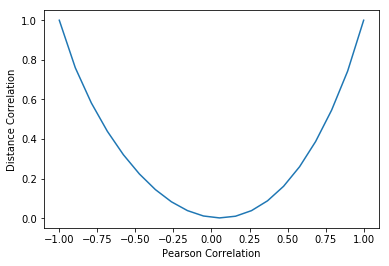

In [6]:
plt.plot(xvals,yvals)
plt.xlabel("Pearson Correlation")
plt.ylabel("Distance Correlation")

Now, we are ready to do a NN example.  The example is a 2D case, where feature 1 is used for classification and feature 2 ("mass") is not used directly, but we want to decorrelate it from the NN output.

It is easy to modify this and add more features.  All that is required is that the mass feature is the last one.  You can also add the mass feature into the list of features to use for classification by having it be the penultimate and the last feature, i.e.

features = (feature 1, feature 2, ..., mass, mass)

In [21]:
from keras import backend as K
import keras.layers as layers
from keras.models import Model
from keras import Sequential
from keras.layers import Lambda, Dense, Flatten
from sklearn.metrics import roc_curve, roc_auc_score
from keras.losses import binary_crossentropy
import tensorflow as tf

The background and signal are both 2D Gaussians.  $\rho$ controls the correlation between feature 1 and feature 2 for the background (uncorrelated for the signal).

In [200]:
N = 20000
rho = -0.5 #1 means fully correlated, 0 means uncorrelated.
z0 = np.random.normal(0.,1.,N)
z1 = np.random.normal(0.,1.,N)
X = z1*rho + z0*(1.-rho**2)**0.5
Y = z1
background_x = tuple(zip(X, Y))  
background_y = np.zeros(len(background_x))

rho = 1. #1 means fully correlated, 0 means uncorrelated.
z0 = np.random.normal(1,0.1,N)
z1 = np.random.normal(1,0.1,N)
X = z0
Y = z1
signal_x = tuple(zip(X, Y)) 
signal_y = np.ones(len(signal_x))

X = np.concatenate([background_x,signal_x])
Y = np.concatenate([background_y,signal_y])

is_train = np.random.rand(X.shape[0])<0.85

X_train = X[is_train]
Y_train = Y[is_train]

X_val = X[~is_train]
Y_val = Y[~is_train]

Text(0,0.5,'feature 2 (= mass)')

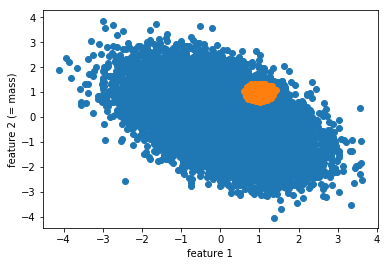

In [201]:
plt.scatter(np.array(background_x)[:,0],np.array(background_x)[:,1])
plt.scatter(np.array(signal_x)[:,0],np.array(signal_x)[:,1])
plt.xlabel("feature 1")
plt.ylabel("feature 2 (= mass)")

In [202]:
Nepochs = 5

def redacted_set(x):
    #Returns everything except the last element.  This is the decorrelation target ("Mass")
    return x[:,0:-1]

#This network is rather generic and simple.  You can swap it out with something more 
#complicated.  Just need to use the custom first layer to separate out the mass if 
#you don't want it to be used directly in the training (aside from the decorrelation penality).

model = Sequential()
model.add(Lambda(redacted_set,input_shape =(2,)))
model.add(Dense(128, activation='relu')) 
model.add(layers.Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hist_model = model.fit(X_train, Y_train, epochs=Nepochs, batch_size=128,validation_data=(X_val, Y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_32 (Lambda)           (None, 1)                 0         
_________________________________________________________________
dense_67 (Dense)             (None, 128)               256       
_________________________________________________________________
dropout_45 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_68 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_46 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 129       
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0
_________________________________________________________________
Train 

In [203]:
preds = model.predict(X_val)
fpr, tpr, _ = roc_curve(Y_val, 1-preds)

Text(0,0.5,'1 - False Positive Rate')

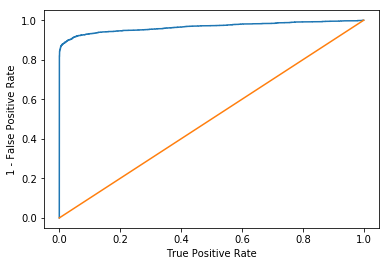

In [204]:
plt.plot(tpr,fpr)
plt.plot([0,1],[0,1])
plt.xlabel("True Positive Rate")
plt.ylabel("1 - False Positive Rate")

Now, the Keras version of DisCo.  This is embeded as a custom loss function.  You can easily swap out the cross entropy for something else (e.g. MSE).

In [205]:
def DisCo(y_true, y_pred, x_in, alpha = 0.):
    #alpha determines the amount of decorrelation; 0 means no decorrelation.
    #Note that the decorrelating feature is also used for learning.
    
    X_in = tf.gather(x_in, [1], axis=1) #decorrelate with the second element of the input (=mass)
    Y_in = y_pred

    #Only require decorrelation for the background.
    mymaskX = tf.where(Y_in<1,K.ones_like(X_in),K.zeros_like(X_in))
    mymaskY = tf.where(Y_in<1,K.ones_like(Y_in),K.zeros_like(Y_in))
    X = tf.boolean_mask(X_in, mymaskX)
    Y = tf.boolean_mask(Y_in, mymaskY)
    
    LX = K.shape(X)[0]
    LY = K.shape(Y)[0]
    
    X=K.reshape(X,shape=(LX,1))
    Y=K.reshape(Y,shape=(LY,1))    
    
    ajk = K.abs(K.reshape(K.repeat(X,LX),shape=(LX,LX)) - K.transpose(X))
    bjk = K.abs(K.reshape(K.repeat(Y,LY),shape=(LY,LY)) - K.transpose(Y))

    Ajk = ajk - K.mean(ajk,axis=0)[None, :] - K.mean(ajk,axis=1)[:, None] + K.mean(ajk)
    Bjk = bjk - K.mean(bjk,axis=0)[None, :] - K.mean(bjk,axis=1)[:, None] + K.mean(bjk)

    dcor = K.sum(Ajk*Bjk) / K.sqrt(K.sum(Ajk*Ajk)*K.sum(Bjk*Bjk))    
    
    return binary_crossentropy(y_true,y_pred) + alpha*dcor

In [212]:
model.compile(loss=lambda y_true, y_pred: DisCo(y_true, y_pred, model.input, alpha = 2.), optimizer='adam', metrics=['accuracy'])
hist_model = model.fit(X_train, Y_train, epochs=Nepochs, batch_size=128,validation_data=(X_val, Y_val))

/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 33955 samples, validate on 6045 samples
Epoch 1/5
33955/33955 [==============================] - 7s 216us/step - loss: 0.6295 - acc: 0.8158 - val_loss: 0.6223 - val_acc: 0.7844
Epoch 2/5
33955/33955 [==============================] - 3s 90us/step - loss: 0.6116 - acc: 0.7781 - val_loss: 0.6258 - val_acc: 0.7801
Epoch 3/5
33955/33955 [==============================] - 3s 91us/step - loss: 0.6107 - acc: 0.7617 - val_loss: 0.6397 - val_acc: 0.7686
Epoch 4/5
33955/33955 [==============================] - 3s 90us/step - loss: 0.6086 - acc: 0.7707 - val_loss: 0.6378 - val_acc: 0.7725
Epoch 5/5
33955/33955 [==============================] - 3s 90us/step - loss: 0.6098 - acc: 0.7681 - val_loss: 0.6248 - val_acc: 0.7720


In [213]:
preds = model.predict(X_val)
fpr0, tpr0, _ = roc_curve(Y_val, 1-preds)

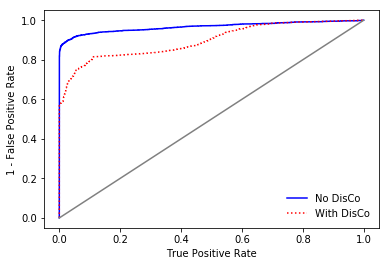

In [216]:
plt.plot(tpr,fpr,color='blue',label="No DisCo")
plt.plot(tpr0,fpr0,linestyle=":",color='red',label="With DisCo")
plt.plot([0,1],[0,1],color='gray')
plt.xlabel("True Positive Rate")
plt.ylabel("1 - False Positive Rate")
plt.legend(frameon=False)

As expected, the performance is worse when using DisCo.  Let's take a closer look at the impact of the hyperparameter by scanning it.

In [226]:
Nepochs = 5
xvals = []
yvals = []
yvals2 = []
yvals3 = []
for alpha in np.linspace(0,5,10):
    print(alpha)
    model = Sequential()
    model.add(Lambda(redacted_set,input_shape =(2,)))
    model.add(Dense(128, activation='relu')) 
    model.add(layers.Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss=lambda y_true, y_pred: DisCo(y_true, y_pred, model.input, alpha = alpha), optimizer='adam', metrics=['accuracy'])
    hist_model = model.fit(X_train, Y_train, epochs=Nepochs, batch_size=128,validation_data=(X_val, Y_val))
    xvals+=[alpha]
    preds = model.predict(X_val)
    yvals+=[roc_auc_score(Y_val,preds)]
    yvals2+=[DisCo_np(X_val[:,0],preds)]
    yvals3+=[DisCo_np(X_val[:,1],preds)]

0.0


/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 33955 samples, validate on 6045 samples
Epoch 1/5
33955/33955 [==============================] - 8s 249us/step - loss: 0.3557 - acc: 0.8646 - val_loss: 0.2071 - val_acc: 0.9227
Epoch 2/5
33955/33955 [==============================] - 3s 96us/step - loss: 0.2039 - acc: 0.9292 - val_loss: 0.1834 - val_acc: 0.9352
Epoch 3/5
33955/33955 [==============================] - 3s 96us/step - loss: 0.1955 - acc: 0.9314 - val_loss: 0.1824 - val_acc: 0.9366
Epoch 4/5
33955/33955 [==============================] - 3s 93us/step - loss: 0.1924 - acc: 0.9333 - val_loss: 0.1811 - val_acc: 0.9353
Epoch 5/5
33955/33955 [==============================] - 3s 98us/step - loss: 0.1913 - acc: 0.9329 - val_loss: 0.1802 - val_acc: 0.9343
0.5555555555555556


/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 33955 samples, validate on 6045 samples
Epoch 1/5
33955/33955 [==============================] - 10s 283us/step - loss: 0.4594 - acc: 0.8448 - val_loss: 0.2786 - val_acc: 0.9031
Epoch 2/5
33955/33955 [==============================] - 3s 99us/step - loss: 0.3807 - acc: 0.9131 - val_loss: 0.2392 - val_acc: 0.9231
Epoch 3/5
33955/33955 [==============================] - 3s 94us/step - loss: 0.3758 - acc: 0.9238 - val_loss: 0.2263 - val_acc: 0.9259
Epoch 4/5
33955/33955 [==============================] - 3s 93us/step - loss: 0.3750 - acc: 0.9267 - val_loss: 0.2180 - val_acc: 0.9320
Epoch 5/5
33955/33955 [==============================] - 3s 93us/step - loss: 0.3744 - acc: 0.9292 - val_loss: 0.2234 - val_acc: 0.9299
1.1111111111111112


/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 33955 samples, validate on 6045 samples
Epoch 1/5
33955/33955 [==============================] - 9s 266us/step - loss: 0.5920 - acc: 0.7608 - val_loss: 0.4572 - val_acc: 0.8553
Epoch 2/5
33955/33955 [==============================] - 3s 93us/step - loss: 0.5157 - acc: 0.8620 - val_loss: 0.4047 - val_acc: 0.8710
Epoch 3/5
33955/33955 [==============================] - 3s 92us/step - loss: 0.5121 - acc: 0.8685 - val_loss: 0.3913 - val_acc: 0.8768
Epoch 4/5
33955/33955 [==============================] - 3s 94us/step - loss: 0.5109 - acc: 0.8740 - val_loss: 0.3923 - val_acc: 0.8736
Epoch 5/5
33955/33955 [==============================] - 3s 92us/step - loss: 0.5090 - acc: 0.8691 - val_loss: 0.3926 - val_acc: 0.8728
1.6666666666666667


/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 33955 samples, validate on 6045 samples
Epoch 1/5
33955/33955 [==============================] - 9s 275us/step - loss: 0.6329 - acc: 0.7378 - val_loss: 0.5976 - val_acc: 0.7974
Epoch 2/5
33955/33955 [==============================] - 3s 94us/step - loss: 0.5909 - acc: 0.7946 - val_loss: 0.5808 - val_acc: 0.8008
Epoch 3/5
33955/33955 [==============================] - 3s 95us/step - loss: 0.5895 - acc: 0.7945 - val_loss: 0.5790 - val_acc: 0.7990
Epoch 4/5
33955/33955 [==============================] - 3s 97us/step - loss: 0.5866 - acc: 0.7959 - val_loss: 0.5762 - val_acc: 0.7997
Epoch 5/5
33955/33955 [==============================] - 3s 93us/step - loss: 0.5862 - acc: 0.7905 - val_loss: 0.5674 - val_acc: 0.8038
2.2222222222222223


/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 33955 samples, validate on 6045 samples
Epoch 1/5
33955/33955 [==============================] - 10s 306us/step - loss: 0.7183 - acc: 0.6233 - val_loss: 0.7315 - val_acc: 0.7451
Epoch 2/5
33955/33955 [==============================] - 3s 97us/step - loss: 0.6451 - acc: 0.7489 - val_loss: 0.6813 - val_acc: 0.7643
Epoch 3/5
33955/33955 [==============================] - 3s 101us/step - loss: 0.6386 - acc: 0.7583 - val_loss: 0.6812 - val_acc: 0.7557
Epoch 4/5
33955/33955 [==============================] - 3s 98us/step - loss: 0.6342 - acc: 0.7427 - val_loss: 0.6789 - val_acc: 0.7535
Epoch 5/5
33955/33955 [==============================] - 3s 101us/step - loss: 0.6328 - acc: 0.7422 - val_loss: 0.6839 - val_acc: 0.7467
2.7777777777777777


/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 33955 samples, validate on 6045 samples
Epoch 1/5
33955/33955 [==============================] - 10s 288us/step - loss: 0.7754 - acc: 0.5324 - val_loss: 0.8932 - val_acc: 0.7186
Epoch 2/5
33955/33955 [==============================] - 3s 91us/step - loss: 0.7057 - acc: 0.7009 - val_loss: 0.7869 - val_acc: 0.7323
Epoch 3/5
33955/33955 [==============================] - 3s 96us/step - loss: 0.6775 - acc: 0.7232 - val_loss: 0.7686 - val_acc: 0.7337
Epoch 4/5
33955/33955 [==============================] - 3s 97us/step - loss: 0.6698 - acc: 0.7238 - val_loss: 0.7729 - val_acc: 0.7199
Epoch 5/5
33955/33955 [==============================] - 3s 101us/step - loss: 0.6658 - acc: 0.7157 - val_loss: 0.7552 - val_acc: 0.7317
3.3333333333333335


/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 33955 samples, validate on 6045 samples
Epoch 1/5
33955/33955 [==============================] - 10s 281us/step - loss: 0.7932 - acc: 0.4992 - val_loss: 0.9069 - val_acc: 0.2984
Epoch 2/5
33955/33955 [==============================] - 3s 94us/step - loss: 0.7891 - acc: 0.5404 - val_loss: 0.9618 - val_acc: 0.6971
Epoch 3/5
33955/33955 [==============================] - 3s 91us/step - loss: 0.7695 - acc: 0.5636 - val_loss: 0.9424 - val_acc: 0.7342
Epoch 4/5
33955/33955 [==============================] - 3s 93us/step - loss: 0.7540 - acc: 0.5998 - val_loss: 0.9160 - val_acc: 0.7274
Epoch 5/5
33955/33955 [==============================] - 3s 93us/step - loss: 0.7349 - acc: 0.6406 - val_loss: 0.8544 - val_acc: 0.7371
3.8888888888888893


/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 33955 samples, validate on 6045 samples
Epoch 1/5
33955/33955 [==============================] - 10s 283us/step - loss: 0.8133 - acc: 0.5434 - val_loss: 0.9642 - val_acc: 0.7495
Epoch 2/5
33955/33955 [==============================] - 3s 93us/step - loss: 0.7887 - acc: 0.5703 - val_loss: 0.9540 - val_acc: 0.7436
Epoch 3/5
33955/33955 [==============================] - 3s 93us/step - loss: 0.7847 - acc: 0.5765 - val_loss: 0.8859 - val_acc: 0.5806
Epoch 4/5
33955/33955 [==============================] - 3s 94us/step - loss: 0.7774 - acc: 0.5858 - val_loss: 0.9379 - val_acc: 0.7371
Epoch 5/5
33955/33955 [==============================] - 3s 94us/step - loss: 0.7584 - acc: 0.6211 - val_loss: 0.9107 - val_acc: 0.7113
4.444444444444445


/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 33955 samples, validate on 6045 samples
Epoch 1/5
33955/33955 [==============================] - 10s 306us/step - loss: 0.8272 - acc: 0.4858 - val_loss: 0.9856 - val_acc: 0.7577
Epoch 2/5
33955/33955 [==============================] - 3s 97us/step - loss: 0.8079 - acc: 0.4968 - val_loss: 0.9625 - val_acc: 0.4106
Epoch 3/5
33955/33955 [==============================] - 3s 101us/step - loss: 0.8031 - acc: 0.5127 - val_loss: 0.8136 - val_acc: 0.6966
Epoch 4/5
33955/33955 [==============================] - 3s 98us/step - loss: 0.8027 - acc: 0.5057 - val_loss: 0.9265 - val_acc: 0.3806
Epoch 5/5
33955/33955 [==============================] - 3s 96us/step - loss: 0.8037 - acc: 0.5084 - val_loss: 0.8851 - val_acc: 0.7429
5.0


/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 33955 samples, validate on 6045 samples
Epoch 1/5
33955/33955 [==============================] - 11s 314us/step - loss: 0.8540 - acc: 0.5323 - val_loss: 1.0110 - val_acc: 0.7320
Epoch 2/5
33955/33955 [==============================] - 3s 101us/step - loss: 0.8241 - acc: 0.5627 - val_loss: 1.0745 - val_acc: 0.7093
Epoch 3/5
33955/33955 [==============================] - 3s 96us/step - loss: 0.8165 - acc: 0.5701 - val_loss: 1.0271 - val_acc: 0.7504
Epoch 4/5
33955/33955 [==============================] - 3s 98us/step - loss: 0.8086 - acc: 0.5757 - val_loss: 0.9744 - val_acc: 0.6893
Epoch 5/5
33955/33955 [==============================] - 3s 99us/step - loss: 0.8072 - acc: 0.5852 - val_loss: 1.0426 - val_acc: 0.7586


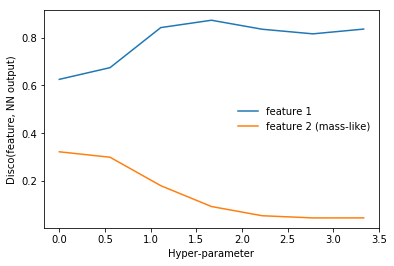

In [227]:
plt.plot(xvals[0:7],yvals2[0:7],label="feature 1")
plt.plot(xvals[0:7],yvals3[0:7],label="feature 2 (mass-like)")
plt.xlabel("Hyper-parameter")
plt.ylabel("Disco(feature, NN output)")
plt.legend(frameon=False)

Text(0,0.5,'AUC')

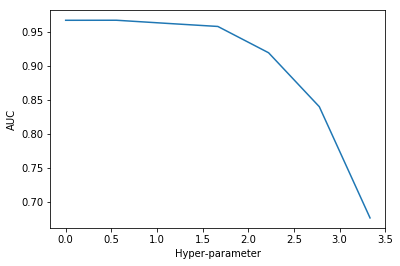

In [228]:
plt.plot(xvals[0:7],yvals[0:7])
plt.xlabel("Hyper-parameter")
plt.ylabel("AUC")

So the performance is worse, but the decorrelation is better!  So DisCo seems to be doing its job.